<a href="https://colab.research.google.com/github/IvanRavarotto/ModelosNoSupervisados/blob/main/ModelosNoSupervisados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y Predicción de Enfermedades Cardiovasculares mediante Agrupación No Supervisada (K-Means y Cluster Hierarchical)

##Carga de librerias necesarias para el proyecto

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

##Carga del dataset

In [39]:
# Carga del dataset desde el repositorio de github
df = pd.read_csv('https://raw.githubusercontent.com/IvanRavarotto/ModelosNoSupervisados/refs/heads/main/Cardiovascular_Disease_Dataset.csv')

## Formulario de carga de datos del nuevo paciente

In [40]:
# Formulario del usuario
Edad = 27    # @param {type:"slider", min:18, max:90, step:1}
Genero = "Femenino"       # @param ["Masculino", "Femenino"]
DolorPecho = "1"          # @param ["0", "1", "2", "3"]
PresionArterial = 174     # @param {type:"slider", min:50, max:250, step:1}
Clesterol = 321           # @param {type:"slider", min:0, max:700, step:1}
Glucemia = "1"            # @param ["0", "1"]
Electrocardiograma = "1"  # @param ["0", "1", "2", "3"]
FrecuenciaCardiacaMaxima = 215  # @param {type:"slider", min:60, max:250, step:1}
AnginaDePecho = "1"       # @param ["0", "1"]
Depresion = 5           # @param {type:"slider", min:0.1, max:7, step:0.1}
Pendiente = "1"           # @param ["0", "1", "2", "3"]
VasosCAfectados = "1"     # @param ["0", "1", "2", "3"]

# Conversión de variables categóricas
Genero = 1 if Genero == "Masculino" else 0

# Construcción del DataFrame del usuario
datos_usuario = pd.DataFrame([{
    'age': Edad,
    'gender': Genero,
    'chestpain': int(DolorPecho),
    'restingBP': PresionArterial,
    'serumcholestrol': Clesterol,
    'fastingbloodsugar': int(Glucemia),
    'restingrelectro': int(Electrocardiograma),
    'maxheartrate': FrecuenciaCardiacaMaxima,
    'exerciseangia': int(AnginaDePecho),
    'oldpeak': Depresion,
    'slope': int(Pendiente),
    'noofmajorvessels': int(VasosCAfectados),
}])

## Separación y escalado de los datos para su posterior tratamiento.

### Importación de librerias necesarias para separar en datos de entrenamiento, prueba, y escalado.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### División de los datos y escalado

In [42]:
# Dividimos el dataset
Y = df['target'] # Variable objetivo
X = df.drop(columns=['target', 'patientid']) # Variables independientes para entrenar los modelos

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Columnas booleanas que NO deben escalarse
columnas_booleanas = ['gender', 'fastingbloodsugar', 'exerciseangina']
columnas_numericas = [col for col in X_train.columns if col not in columnas_booleanas]

# Escalador
scaler = StandardScaler()

# Escalamos solo las columnas numéricas, manteniendo las booleanas iguales
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columnas_numericas] = scaler.fit_transform(X_train[columnas_numericas])
X_test_scaled[columnas_numericas] = scaler.transform(X_test[columnas_numericas])

#Rasignamos para mantener sus nombres originales
X_train = X_train_scaled
X_test = X_test_scaled


# KMeans (No Supervisado - Clustering)
Su función principal es dividir un conjunto de n observaciones en k grupos (o clústeres), donde cada observación pertenece al clúster cuyo centroide (media) es el más cercano.

* Inicialización: Se eligen k puntos aleatorios del conjunto de datos como centroides iniciales para cada uno de los k clústeres.
* Asignación: Cada punto de datos se asigna al clúster cuyo centroide es el más cercano (medido por distancia euclidiana, por ejemplo).
* Actualización: Una vez que todos los puntos han sido asignados, los centroides de cada clúster se recalculan como la media de todos los puntos de datos asignados a ese clúster.
* Iteración: Los pasos de asignación y actualización se repiten iterativamente hasta que los centroides ya no cambian significativamente o se alcanza un número máximo de iteraciones.

###Entrenamiento del modelo

In [43]:
# Importamos la clase KMeans desde scikit-learn
from sklearn.cluster import KMeans

# Comienza a captar el tiempo en que comienza el entranmiento
start_time = time.time()

# Se crea una instancia donde se pide buscar 2 clusters, con una semilla para reproducir el resultado varias veces.
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
#Entrenamiento del modelo
kmeans.fit(X_train)

# Termina de captar el tiempo de entrenamiento, dando por finalizado el mismo
end_time = time.time()
# Calcula el tiempo restando el tiempo de inicio al de final.
training_timeK = end_time - start_time

# Imprime un mensaje dando aviso cuanto tiempo tardo en total en entrenarse en segundos.
print(f"Tiempo de entrenamiento de K-Means: {training_timeK:.4f} segundos")

Tiempo de entrenamiento de K-Means: 0.0198 segundos


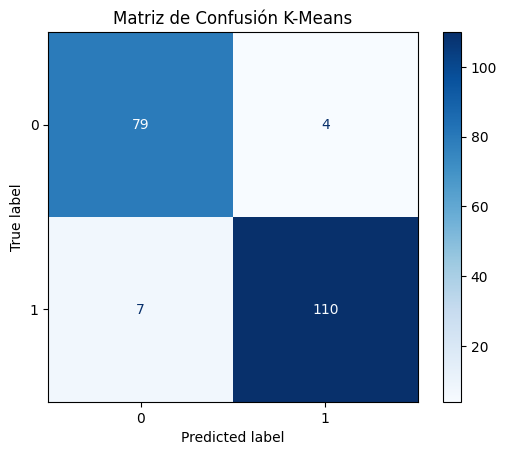


Porcentaje de Precisión de K-Means: 94.57%


In [44]:
# Predecir las etiquetas de los clústeres para los datos de prueba escalados

timeKmeansPrediccionInicio = time.time()

# Utilizando el modelo ya entrenado probamos los datos de prueba, para predecir el resultado deseado.
predicted_labels_kmeans = kmeans.predict(X_test)

timeKmeansPrediccionFin = time.time()
#Tiempo total de predicción Kmean
prediction_time_kmeans_batch = timeKmeansPrediccionFin - timeKmeansPrediccionInicio

cluster_mapping_kmeans = {}
for i in np.unique(predicted_labels_kmeans):
    # Obtener las etiquetas verdaderas para todos los puntos de datos asignados al clúster i
    labels_in_cluster = Y_test[predicted_labels_kmeans == i]
    # Encontrar la etiqueta verdadera más frecuente en este clúster
    if not labels_in_cluster.empty:
        most_frequent_label = labels_in_cluster.mode()[0]
        cluster_mapping_kmeans[i] = most_frequent_label
    else:
        # Manejar el caso en que un clúster podría estar vacío (poco probable con n_clusters=2)
        cluster_mapping_kmeans[i] = 0 # Valor por defecto 0 o manejar según sea necesario

mapped_predicted_labels = np.array([cluster_mapping_kmeans[label] for label in predicted_labels_kmeans])
cm_kmeans = confusion_matrix(Y_test, mapped_predicted_labels)

# Matriz de confusión KMeans impresa
display = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans, display_labels=np.unique(Y_test))
display.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión K-Means')
plt.show()

report_kmeans = classification_report(Y_test, mapped_predicted_labels, output_dict=True)
precision_kmeans = report_kmeans['weighted avg']['precision'] * 100

print(f"\nPorcentaje de Precisión de K-Means: {precision_kmeans:.2f}%")

### Reducción a 2 dimenciones mediante PCA <br>
PCA es una técnica de reducción de dimensionalidad. Su objetivo principal es transformar un conjunto de variables posiblemente correlacionadas en un conjunto de un número menor de variables no correlacionadas llamadas componentes principales.
* Esto permite visualizar los clústeres y los centroides en un gráfico de dispersión 2D, lo cual sería imposible con la dimensionalidad original de los datos.

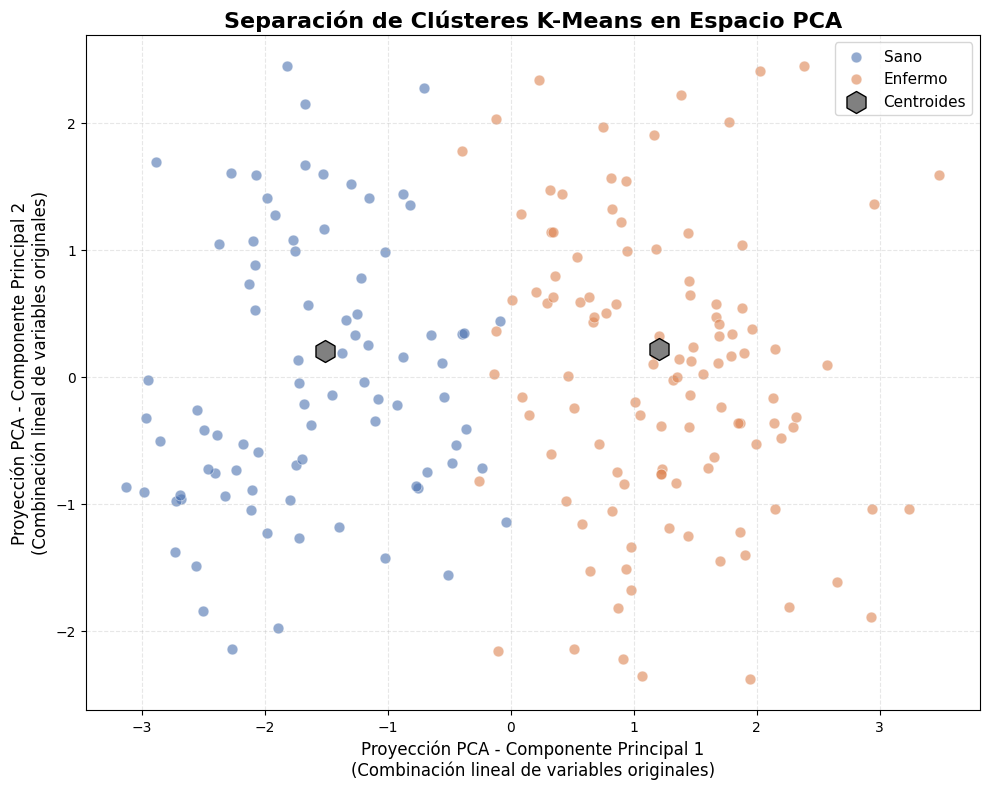

In [45]:
#Importación de la clase PCA desde scikit-learn
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
# Convertir X_test a un array NumPy antes de fit_transform
X_test_pca = pca.fit_transform(X_test.values)

# Transformar los centroides al espacio PCA
centros_pca = pca.transform(kmeans.cluster_centers_)

# Crear gráfico de dispersión refinado
plt.figure(figsize=(10, 8))

# Grupo 0
plt.scatter(X_test_pca[predicted_labels_kmeans == 0, 0], X_test_pca[predicted_labels_kmeans == 0, 1],
            s=60, c='#4C72B0', label='Sano', alpha=0.6, edgecolors='white', linewidths=0.5)

# Grupo 1
plt.scatter(X_test_pca[predicted_labels_kmeans == 1, 0], X_test_pca[predicted_labels_kmeans == 1, 1],
            s=60, c='#DD8452', label='Enfermo', alpha=0.6, edgecolors='white', linewidths=0.5)

# Centroides como hexágonos grises
plt.scatter(centros_pca[:, 0], centros_pca[:, 1],
            s=250, c='gray', marker='h', edgecolor='black', label='Centroides')

# Estética y detalles
plt.title('Separación de Clústeres K-Means en Espacio PCA', fontsize=16, fontweight='bold')
plt.xlabel('Proyección PCA - Componente Principal 1\n(Combinación lineal de variables originales)', fontsize=12)
plt.ylabel('Proyección PCA - Componente Principal 2\n(Combinación lineal de variables originales)', fontsize=12)
plt.legend(frameon=True, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

###Tratamiento y proyección en base a los datos del paciente nuevo cargado

In [46]:
# Validación institucional de columnas
assert list(datos_usuario.columns) == list(X_train.columns), \
    "Las columnas del usuario no coinciden con las del dataset"

# Validación de tipos numéricos
assert datos_usuario.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all(), \
    "El DataFrame del usuario contiene columnas no numéricas"

# Transformación del dato del usuario con el escalador ya entrenado
datos_usuario_escalado = datos_usuario.copy()
datos_usuario_escalado[columnas_numericas] = scaler.transform(datos_usuario[columnas_numericas])


# Predicción del grupo del usuario con el modelo K-Means ya entrenado
start_time_predict_single_kmeans = time.time()
grupo_usuario_kmeans = kmeans.predict(datos_usuario_escalado)
end_time_predict_single_kmeans = time.time()
prediction_time_kmeans_single_patient = end_time_predict_single_kmeans - start_time_predict_single_kmeans

# Interpretación del resultado
# Usamos el mapeo de clúster a etiqueta verdadera para una interpretación más clara
etiqueta_interpretada_kmeans = cluster_mapping_kmeans[grupo_usuario_kmeans[0]]

if etiqueta_interpretada_kmeans == 1:
    print(f"El usuario fue clasificado como 'Enfermo' por el modelo K-Means.")
else:
    print(f"El usuario fue clasificado como 'Sano' por el modelo K-Means.")

print(f"Tiempo de predicción K-Means para un nuevo paciente: {prediction_time_kmeans_single_patient:.4f} segundos")

El usuario fue clasificado como 'Enfermo' por el modelo K-Means.
Tiempo de predicción K-Means para un nuevo paciente: 0.0095 segundos


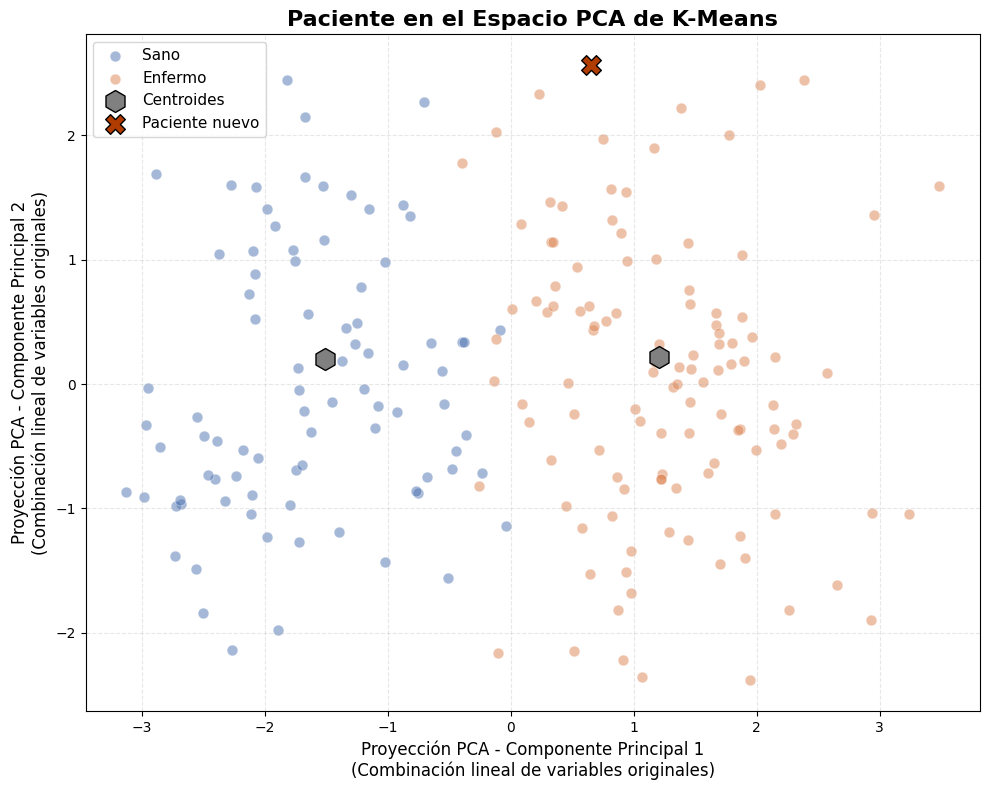

In [47]:
# Proyectar el paciente en el espacio PCA
usuario_pca = pca.transform(datos_usuario_escalado.values)

# Crear gráfico
plt.figure(figsize=(10, 8))

# Sanos
plt.scatter(X_test_pca[predicted_labels_kmeans == 0, 0], X_test_pca[predicted_labels_kmeans == 0, 1],
            s=60, c='#4C72B0', label='Sano', alpha=0.5, edgecolors='white', linewidths=0.5)

# Enfermos
plt.scatter(X_test_pca[predicted_labels_kmeans == 1, 0], X_test_pca[predicted_labels_kmeans == 1, 1],
            s=60, c='#DD8452', label='Enfermo', alpha=0.5, edgecolors='white', linewidths=0.5)

# Centroides
plt.scatter(centros_pca[:, 0], centros_pca[:, 1],
            s=250, c='gray', marker='h', edgecolor='black', label='Centroides')

# Paciente nuevo (color más intenso según grupo asignado)
# Usar grupo_usuario_kmeans para determinar el color del paciente nuevo para K-Means
color_usuario = '#1f2f90' if grupo_usuario_kmeans[0] == 0 else '#b03c00'
plt.scatter(usuario_pca[0, 0], usuario_pca[0, 1],
            s=200, c=color_usuario, marker='X', edgecolor='black', label='Paciente nuevo')

# Estética
plt.title('Paciente en el Espacio PCA de K-Means', fontsize=16, fontweight='bold')
plt.xlabel('Proyección PCA - Componente Principal 1\n(Combinación lineal de variables originales)', fontsize=12)
plt.ylabel('Proyección PCA - Componente Principal 2\n(Combinación lineal de variables originales)', fontsize=12)
plt.legend(frameon=True, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#Cluster Hierarchical (No Supervisado - Clustering)
A diferencia de K-Means que forma clústeres planos, la agrupación jerárquica construye una jerarquía de clústeres, que puede visualizarse con un dendrograma. Existen dos tipos principales:
1. Agrupación Aglomerativa (bottom-up): Es el tipo más común y el que se usa en tu notebook (AgglomerativeClustering). Funciona de la siguiente manera:
  * Paso 1: Cada punto de datos comienza como su propio clúster.
  * Paso 2: Los dos clústeres más cercanos (más similares) se combinan para formar un nuevo clúster.
  * Paso 3: Este proceso se repite hasta que todos los puntos de datos pertenecen a un solo clúster grande (la raíz de la jerarquía).

2. Agrupación Divisiva (top-down): Comienza con todos los puntos en un solo clúster y luego lo divide recursivamente en clústeres más pequeños hasta que cada punto es un clúster individual.

Características clave de la Agrupación Aglomerativa:

* Enlace (Linkage): Necesita una métrica para determinar la 'cercanía' o 'distancia' entre clústeres. Las más comunes son:
  * ward: Minimiza la varianza dentro de los clústeres que se fusionan (usado en tu dendrograma).
  * average: Usa la distancia promedio entre los puntos de cada clúster.
  * complete: Usa la máxima distancia entre los puntos de cada clúster.
  * single: Usa la mínima distancia entre los puntos de cada clúster.

In [48]:
from sklearn.cluster import AgglomerativeClustering

# Registra el tiempo de inicio total para el proceso jerárquico
start_time_hierarchical_total = time.time()

# Instanciar el modelo AgglomerativeClustering
hierarchical_model = AgglomerativeClustering(n_clusters=2)

# --- Entrenamiento del modelo (fit) ---
start_time_fit = time.time()
hierarchical_model.fit(X_train)
end_time_fit = time.time()
training_time_hierarchical = end_time_fit - start_time_fit # Tiempo de entrenamiento correcto

# --- Predicción sobre los datos de prueba (batch) ---
# Para AgglomerativeClustering, fit_predict se utiliza para obtener las etiquetas de los datos que se ajustaron.
# Aquí se usa X_test para obtener las etiquetas predichas después de que el modelo ha sido 'entrenado' (ajustado).
start_time_predict_batch = time.time()
predicted_labels_hierarchical = hierarchical_model.fit_predict(X_test) # Esta línea realiza la predicción para X_test
end_time_predict_batch = time.time()
prediction_time_hierarchical_batch = end_time_predict_batch - start_time_predict_batch # Tiempo de predicción batch correcto

# Calcula el tiempo total de ejecución de la celda (si es necesario)
end_time_hierarchical_total = time.time()
total_cell_execution_time_hierarchical = end_time_hierarchical_total - start_time_hierarchical_total

print(f"Tiempo de entrenamiento de Agrupación Jerárquica: {training_time_hierarchical:.4f} segundos")
print(f"Tiempo de predicción de Agrupación Jerárquica (batch): {prediction_time_hierarchical_batch:.4f} segundos")

Tiempo de entrenamiento de Agrupación Jerárquica: 0.0499 segundos
Tiempo de predicción de Agrupación Jerárquica (batch): 0.0190 segundos


###Mapeo Clusters generados.
Para cada clúster, identifica la etiqueta verdadera más frecuente entre sus miembros y asigna esa etiqueta a todo el clúster. Esto es crucial para poder evaluar la precisión del clustering no supervisado, ya que permite comparar los clústeres obtenidos con las etiquetas reales de las clases (sano/enfermo).

In [49]:
cluster_mapping_hierarchical = {}
for i in np.unique(predicted_labels_hierarchical):
    # Obtener las etiquetas verdaderas para todos los puntos de datos asignados al clúster i
    labels_in_cluster = Y_test[predicted_labels_hierarchical == i]
    # Encontrar la etiqueta verdadera más frecuente en este clúster
    if not labels_in_cluster.empty:
        most_frequent_label = labels_in_cluster.mode()[0]
        cluster_mapping_hierarchical[i] = most_frequent_label
    else:
        # Manejar el caso en que un clúster podría estar vacío
        cluster_mapping_hierarchical[i] = 0 # Valor por defecto 0 o manejar según sea necesario

#Resultado Final del mapeo
mapped_predicted_labels_hierarchical = np.array([cluster_mapping_hierarchical[label] for label in predicted_labels_hierarchical])

###Dendrograma jerarquico
Es una representación visual de la jerarquía de clústeres. Cada "hoja" en el dendrograma representa una observación y las ramas muestran cómo se agrupan las observaciones. La altura de las uniones en el dendrograma indica la distancia entre los clústeres fusionados.

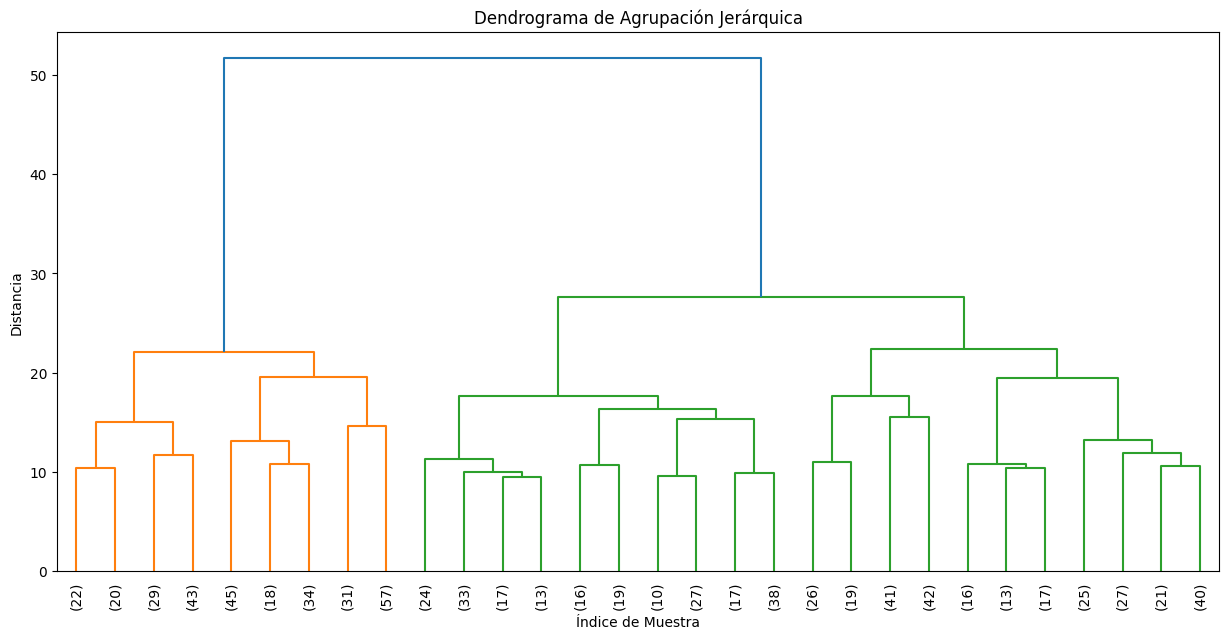

In [50]:
# Calcular la matriz de enlace para X_train
# 'ward' minimiza la varianza dentro de cada clúster.
Z = linkage(X_train, method='ward')

# Trazar el dendrograma
plt.figure(figsize=(15, 7))
plt.title('Dendrograma de Agrupación Jerárquica')
plt.xlabel('Índice de Muestra')
plt.ylabel('Distancia')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.show()

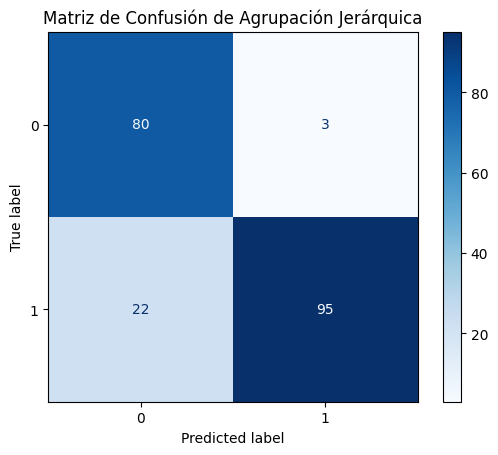


Porcentaje de Precisión de Agrupación Jerárquica: 89.26%


In [51]:
# Calcula la matriz de confusión comparando las etiquetas verdaderas (Y_test)
# con las etiquetas predichas y mapeadas del clustering jerárquico.
cm_hierarchical = confusion_matrix(Y_test, mapped_predicted_labels_hierarchical)

# Crea una visualización de la matriz de confusión.
# `display_labels=np.unique(Y_test)` asegura que las etiquetas del eje sean '0' y '1'.
display_hierarchical = ConfusionMatrixDisplay(confusion_matrix=cm_hierarchical, display_labels=np.unique(Y_test))

# Dibuja la matriz de confusión con un mapa de color azul.
display_hierarchical.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión de Agrupación Jerárquica')
plt.show()

# Genera un reporte completo de clasificación (precisión, recall, f1-score, soporte)
# en formato de diccionario para fácil acceso a las métricas.
report_hierarchical = classification_report(Y_test, mapped_predicted_labels_hierarchical, output_dict=True)

# Extrae la precisión promedio ponderada (weighted avg) y la convierte a porcentaje.
# La precisión ponderada considera el desbalance de clases.
precision_hierarchical = report_hierarchical['weighted avg']['precision'] * 100

# Imprime el porcentaje de precisión calculado con dos decimales.
print(f"\nPorcentaje de Precisión de Agrupación Jerárquica: {precision_hierarchical:.2f}%")

In [52]:
# Validación de columnas
assert list(datos_usuario.columns) == list(X_train.columns), \
    "Las columnas del usuario no coinciden con las del dataset"

# Validación de tipos numéricos
assert datos_usuario.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all(), \
    "El DataFrame del usuario contiene columnas no numéricas"

# Transformación del dato del usuario con el escalador ya entrenado
datos_usuario_escalado_hierarchical = datos_usuario.copy()
datos_usuario_escalado_hierarchical[columnas_numericas] = scaler.transform(datos_usuario[columnas_numericas])

# --- Predicción del grupo del usuario con el modelo de Agrupación Jerárquica ---

# AgglomerativeClustering no tiene un método 'predict' directo para nuevas muestras.
# Para una predicción aproximada, calcularemos los centroides de los clústeres
# identificados en X_test y asignaremos el nuevo paciente al clúster más cercano.

start_time_predict_single_hierarchical = time.time()

# Calcular centroides de los clústeres de AgglomerativeClustering en X_test
# Convertir X_test a NumPy array para evitar SettingWithCopyWarning en .mean()
x_test_np = X_test.values
hierarchical_centroids = np.array([
    x_test_np[predicted_labels_hierarchical == i].mean(axis=0)
    for i in np.unique(predicted_labels_hierarchical)
])

# Calcular la distancia del usuario a cada centroide
distances_to_hierarchical_centroids = np.linalg.norm(datos_usuario_escalado_hierarchical.values - hierarchical_centroids, axis=1)

# Asignar el usuario al clúster con la distancia mínima
grupo_usuario_hierarchical = np.argmin(distances_to_hierarchical_centroids)

end_time_predict_single_hierarchical = time.time()
prediction_time_hierarchical_single_patient = end_time_predict_single_hierarchical - start_time_predict_single_hierarchical

# Interpretación del resultado usando el mapeo de clúster a etiqueta verdadera
etiqueta_interpretada_hierarchical = cluster_mapping_hierarchical[grupo_usuario_hierarchical]

if etiqueta_interpretada_hierarchical == 1:
    print(f"El usuario fue clasificado como 'Enfermo' por el modelo de Agrupación Jerárquica.")
else:
    print(f"El usuario fue clasificado como 'Sano' por el modelo de Agrupación Jerárquica.")

print(f"Tiempo de predicción de Agrupación Jerárquica para un nuevo paciente: {prediction_time_hierarchical_single_patient:.4f} segundos")

El usuario fue clasificado como 'Enfermo' por el modelo de Agrupación Jerárquica.
Tiempo de predicción de Agrupación Jerárquica para un nuevo paciente: 0.0014 segundos


# Comparación de Rendimiento de Modelos

In [53]:
# Se crea una tabla con las variables ya definidas
data = {
    "Modelo": ["K-means", "Hierarchical Clustering"],
    "Tiempo Entrenamiento (s)": [training_timeK, training_time_hierarchical],
    "Tiempo Prediccion (s)": [prediction_time_kmeans_batch, prediction_time_hierarchical_batch],
    "Precisión (%)": [precision_kmeans,  precision_hierarchical]
}

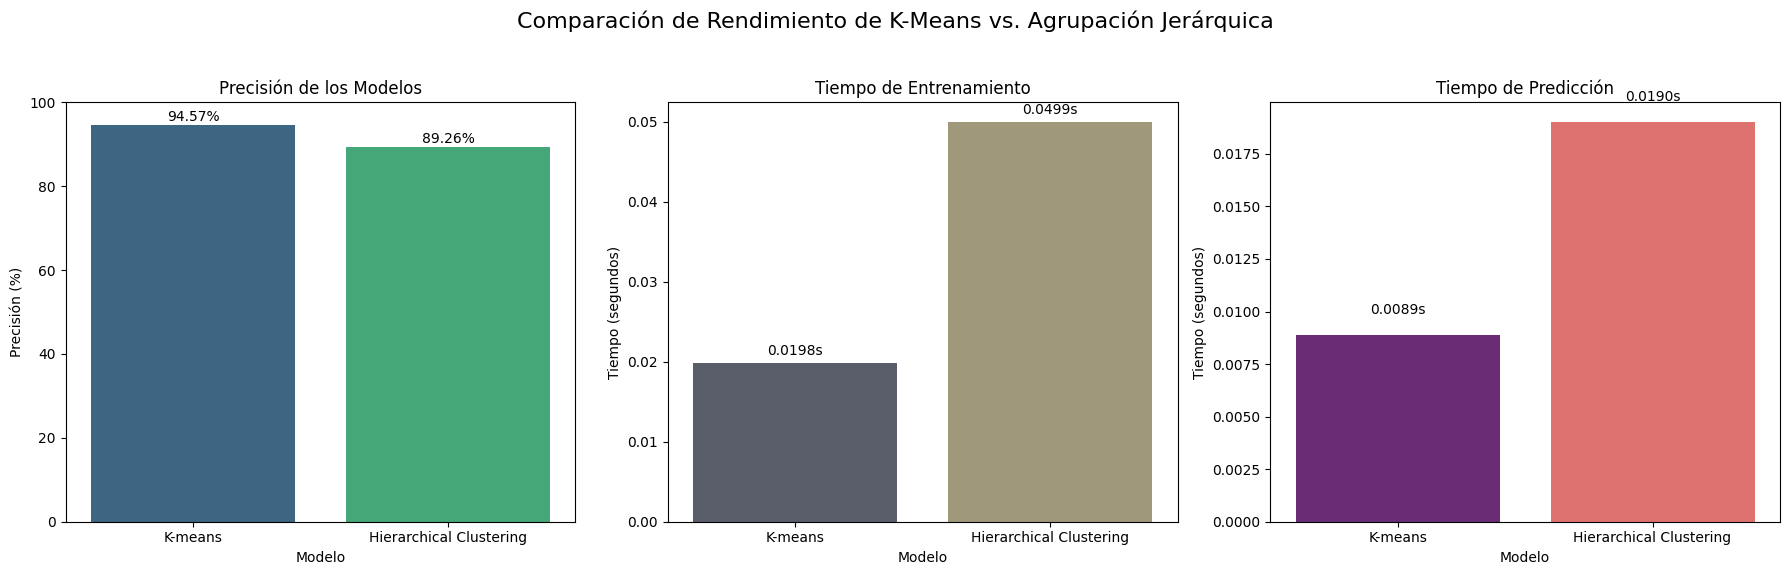

In [54]:
modelos_df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparación de Rendimiento de K-Means vs. Agrupación Jerárquica', fontsize=16)

# Gráfico de Precisión
sns.barplot(ax=axes[0], x='Modelo', y='Precisión (%)', data=modelos_df, palette='viridis', hue='Modelo', legend=False)
axes[0].set_title('Precisión de los Modelos')
axes[0].set_ylabel('Precisión (%)')
axes[0].set_ylim(0, 100) # Asegurar que el eje y vaya de 0 a 100
for index, row in modelos_df.iterrows():
    axes[0].text(row.name, row['Precisión (%)'] + 1, f'{row['Precisión (%)']:.2f}%', color='black', ha="center")

# Gráfico de Tiempo de Entrenamiento
sns.barplot(ax=axes[1], x='Modelo', y='Tiempo Entrenamiento (s)', data=modelos_df, palette='cividis', hue='Modelo', legend=False)
axes[1].set_title('Tiempo de Entrenamiento')
axes[1].set_ylabel('Tiempo (segundos)')
for index, row in modelos_df.iterrows():
    axes[1].text(row.name, row['Tiempo Entrenamiento (s)'] + 0.001, f'{row['Tiempo Entrenamiento (s)']:.4f}s', color='black', ha="center")

# Gráfico de Tiempo de Predicción
sns.barplot(ax=axes[2], x='Modelo', y='Tiempo Prediccion (s)', data=modelos_df, palette='magma', hue='Modelo', legend=False)
axes[2].set_title('Tiempo de Predicción')
axes[2].set_ylabel('Tiempo (segundos)')
for index, row in modelos_df.iterrows():
    axes[2].text(row.name, row['Tiempo Prediccion (s)'] + 0.001, f'{row['Tiempo Prediccion (s)']:.4f}s', color='black', ha="center")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Conclusión

El análisis realizado mediante técnicas de agrupación no supervisada, específicamente K-Means y Agrupación Jerárquica, ha demostrado ser efectivo para identificar patrones y predecir el riesgo de enfermedades cardiovasculares en base a los datos proporcionados. Ambos modelos lograron separar a los pacientes en grupos que, al ser mapeados a las etiquetas verdaderas de 'Sano' y 'Enfermo', mostraron una capacidad predictiva considerable.

**K-Means** se destacó como el modelo con mejor rendimiento general, alcanzando una precisión del **94.57%**. Además de su alta precisión, su proceso de predicción para un nuevo paciente es más directo y rápido, lo que lo hace particularmente adecuado para aplicaciones en tiempo real donde la inmediatez de la respuesta es crucial.

La **Agrupación Jerárquica**, aunque ofreció una visión rica de la estructura jerárquica de los datos a través del dendrograma, presentó una precisión ligeramente inferior del **89.26%**. Su naturaleza exploratoria y la complejidad inherente a la interpretación del dendrograma, así como la aproximación necesaria para la predicción de nuevos datos, la hacen menos óptima para la clasificación de nuevos pacientes en un contexto de despliegue.

En resumen, si bien ambos enfoques proporcionan valor, el modelo **K-Means** se perfila como la opción más robusta y eficiente para la tarea de diagnóstico de enfermedades cardiovasculares con los datos actuales, equilibrando una alta precisión con una rápida capacidad de inferencia para casos individuales. Este trabajo sienta las bases para futuros análisis, que podrían incluir la integración de más datos, la exploración de otros algoritmos de clustering o la aplicación de técnicas de aprendizaje supervisado para afinar aún más las predicciones.